In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import math
# from mpl_toolkits.mplot3d import axes3d
import datetime as dt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

Primero voy a ver que datos me da el dataset.

In [9]:
#Leo el csv de registros
data = pd.read_csv("./Marat_n_BCN_sobran_kilometros_.csv")
crs = {'init': 'epsg:4326'}

# #Añado punto geometrico
geometry = [Point(xy) for xy in zip( data["longitud"], data["latitud"])]

In [8]:
geo_data = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

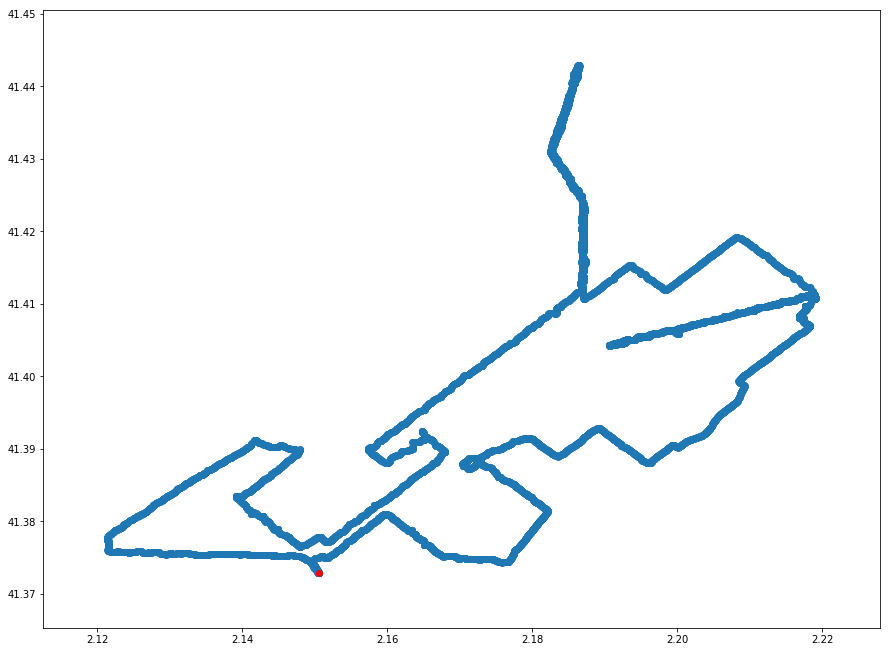

In [7]:
fig,ax=plt.subplots(figsize= (15,15))
geo_data.plot(ax=ax)

geo_data[geo_data['time']== min(geo_data.time)].plot(ax=ax, color = 'red')#start point



In [ ]:
# #Pinto elevación y diferencia de elevación

# grafica= plt.figure(figsize= (20,10))

# grafica=plt.plot(data.elevacion)

# elevacion= data[['elevacion']]
# ant = 0
# s=[]
# for idx, ele in elevacion.iterrows():
#     if (idx == 0 ): ant=ele["elevacion"]
#     s.append(ele["elevacion"]-ant)
#     ant = ele["elevacion"]    
# s= pd.Series(s)

# grafica=plt.plot(s)


# grafica = plt.ylabel("Elevación (m)")
# grafica = plt.title("Cambio de la elevación durante el transcurso del recorrido")

Función para calcular la distancia entre dos puntos geográficos:

$ 2\cdot r \cdot \arcsin(\sqrt{ \sin^{2}(\frac{lat2-lat1}{2})+ \cos(lat1)\cdot \cos(lat2) \cdot  \sin^{2}(\frac{lon2-lon1}{2} })) $

In [51]:
def formulaHaversine(lat1, lon1, lat2, lon2):
    
    r = 6371000#m
    k = math.pi/180 #transformar de grados a radianes
    
    diff_lat = lat2-lat1
    diff_lon = lon2-lon1
    
    a = math.sin((k*diff_lat)/2)**2 + math.cos(k*lat1) * math.cos(k*lat2) * math.sin((k*diff_lon)/2)**2
    c = 2*math.asin(math.sqrt(a))
    return( r * c)

Función para calcular diversas métricas necesarias para el posterior análisis y detectar registros anómalos.

In [52]:
def distancia3D(distancia2D,ele1,ele2):
    diff_ele = ele2-ele1
    d_h = math.sqrt(distancia2D**2 + diff_ele**2)
    return(d_h)

In [53]:
def formateaFecha(stringFecha, stringFormato):
    time = dt.datetime.strptime(stringFecha, stringFormato)
    return(time)

In [54]:
def calculaVelocidadKM(time1, time2, distancia_2_1):
    diff_time = time2 - time1
    v = (distancia_2_1/diff_time.seconds) * 3.6 #k/h
    return(v)

In [55]:
def calculaPendiente(elevacion, distancia):
    p=0
    
    if(distancia!=0):
        p=elevacion/distancia
        
    return(p)

In [56]:
def calculaVelocidadVertKM(time1,time2,incrementoEle):
    diff_time = time2 - time1
    v = (incrementoEle/diff_time.seconds) * 3.6 #k/h
    return(abs(v))


In [57]:
def calculaDireccionVector(lat1,lon1,lat2,lon2):
    direccion=0
    diff_lat=lat2-lat1
    diff_lon=lon2-lon1
    if(diff_lon != 0):
        div_lat_lon =  diff_lat/diff_lon
        direccion= (math.atan(div_lat_lon)*180)/math.pi
    return(direccion)
    

$\tan ^{-1}\left( \frac{lat2-lat1}{lon2-lon1} \right)\cdot \frac{180}{\pi}$

In [58]:
def calculosDetectarAnomalias(data, nombreNuevo):
    distance = list()
    velocidad = list()
    incr_ele = list()
    pendiente = list()
    velocidad_v = list()
    direccion =list()
    cambio_dir=list()
    
    
    lista_time=data['time']

    ele = 0
    lon = 0
    lat = 0
    dirr= 0
    time = lista_time[0]

    for i, fila in data.iterrows():
        if( i == 0):
            distance.append(0)
            velocidad.append(0)
            incr_ele.append(0)
            pendiente.append(0)
            velocidad_v.append(0)
            direccion.append(0)
            cambio_dir.append(0)
        else:
            
            #distancia
            d_2d = formulaHaversine(lat, lon, fila['latitud'], fila['longitud'])
            d_h= distancia3D(d_2d,ele,fila['elevacion'])
            distance.append(d_h)
            
            #velocidad
            t1=time.replace('.000', '')
            t2=fila['time'].replace( '.000', '')
            time_dt1= formateaFecha(t1,'%Y-%m-%dT%H:%M:%SZ')
            time_dt2= formateaFecha(t2,'%Y-%m-%dT%H:%M:%SZ')
            
            v= calculaVelocidadKM(time_dt1, time_dt2, d_h)
            velocidad.append(v)
            
            #Incremento elevación
            diff_ele = fila['elevacion']-ele
            incr_ele.append(diff_ele)
            
            #pendiente
            pendiente.append(calculaPendiente(diff_ele, d_2d))
            
            #Velocidad vertical
            velocidad_v.append(calculaVelocidadVertKM(time_dt1,time_dt2, diff_ele))
               
            #Dirección vector
            new_dirr=calculaDireccionVector(lat,lon,fila['latitud'],fila['longitud'])
            direccion.append(new_dirr)
                
            #Cambio de direccion vector
            cambio_dir.append(abs(new_dirr)-abs(dirr))
            dirr = new_dirr
        
        ele = fila['elevacion']
        lon = fila['longitud']
        lat = fila['latitud']
        time = fila['time']

    data["distancia"]=distance
    data["velocidad"]=velocidad
    data["inc_ele"]=incr_ele
    data["pendiente"]=pendiente
    data["velocidad_v"]=velocidad_v
    data["direccion"]=direccion
    data["cambio_dirr"]=cambio_dir
    
    data.to_csv(nombreNuevo+".csv",index=False)

In [59]:
#calculosDetectarAnomalias(datamedia, "datamediamar")
calculosDetectarAnomalias(data, "datamar")

In [10]:
datamar= pd.read_csv("datamar.csv")
#datamediamar= pd.read_csv("datamediamar.csv")

In [61]:
sum(datamar.distancia)

45279.502055317964

## Eliminación de datos anómalos


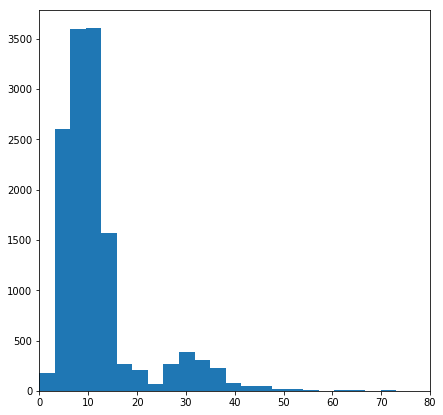

In [69]:
aux=plt.subplots(figsize= (7,7))
hist_vel=plt.hist(datamar.velocidad, bins=40)
aux=plt.xlim(0,80)

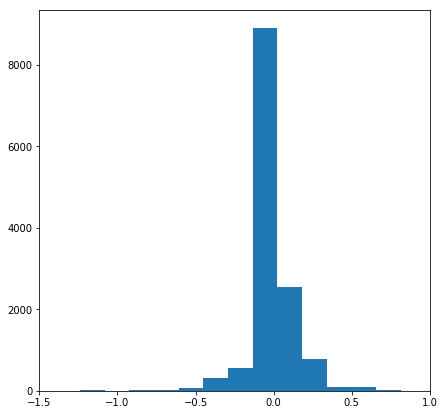

In [75]:
aux=plt.subplots(figsize= (7,7))
hist_vel=plt.hist(datamar.inc_ele, bins=50)
aux=plt.xlim(-1.5,1)

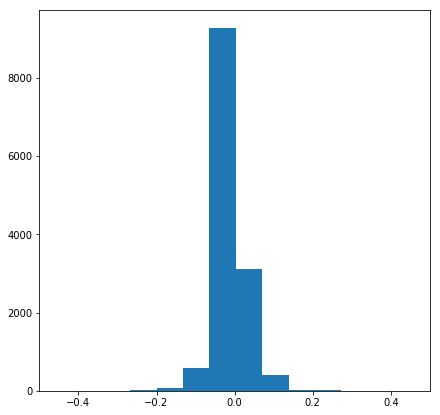

In [77]:
aux=plt.subplots(figsize= (7,7))
hist_vel=plt.hist(datamar.pendiente, bins=50)
aux=plt.xlim(-0.5,0.5)

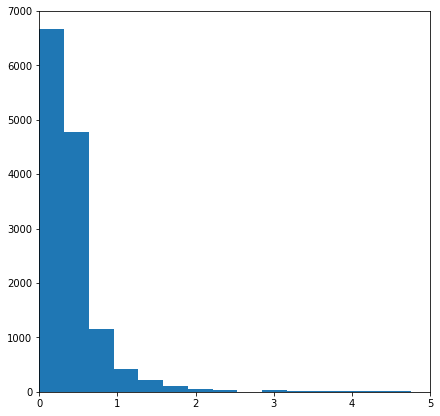

In [83]:
aux=plt.subplots(figsize= (7,7))
hist_vel=plt.hist(datamar.velocidad_v, bins=50)
aux=plt.xlim(0,5)

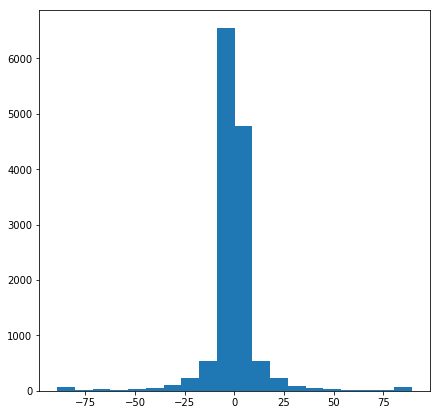

In [89]:
aux=plt.subplots(figsize= (7,7))
hist_vel=plt.hist(datamar.cambio_dirr, bins=20)
#aux=plt.xlim(0,5)

In [101]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [13]:
def eliminaRegistrosPorVelocidad(dataset):
    
    vel = dataset.velocidad
    
    #Calculo el filtro de datos anómalos
    sigma_velocidad= np.std(vel)
    
    hist=plt.hist(vel, bins=60)

    binmax=np.where(hist[0]==hist[0].max())[0][0]
    val_binmax=hist[1][binmax]
    filtro=find_nearest(hist[1],math.ceil(val_binmax+sigma_velocidad*1.5))
    
    #Recorro lo valores de la velocidad
    lista= list()

    for i in np.arange(0,len(vel)):
    
        #n es el valor i de la lista de velocidad
       
        n=vel[i]

        #Si no es el primer valor de la lista
        #Y tampo es el último
        if(i>=1 and i != len(vel)-1):
        
            media=list()
            num=0
        
            #Si i es el segundo elemento de la lista
            #o el anteúltimo, solo cogeré el valor 
            #inmediatemente anterior y siguiente a i
            if(i==1 or i== len(vel)-2):
                num=1
            elif(i==2 or i == len(vel)-3):  #Si es el tercero o el antepenultimo, 
                                            #cojo dos valores inmediatamente anteriores
                                            #y siguientes para la media
                num=2
            else:                           #Para el resto cojo los tres anteriores
                                            #y los tres siguientes
                num=3

            if(num !=0):
                for j in np.arange(-num, num):
                    value=0
                
                    if(j<0):
                        value = lista[i+j]
                    else:
                        value = dataset.velocidad[i+j]
                
                    if(value<45):
                        media.append(value)#Solamente se utilizarán los valores de ese
                                           #rango que no superen los 45 km/h ya que
                                           #es la máxima velocidad registrada por el ser humano.
           
            n= sum(media)/len(media)
            
        if(vel[i] > n*1.5 or vel[i] >filtro):
            n=-99
        else:
            n=vel[i]
            
        lista.append(n)
    
    dataset['velocidad']=lista
    
    dataset = dataset.drop(dataset[dataset.velocidad==-99].index)
    dataset = dataset.reset_index(drop=True)
    return(dataset)

In [103]:
def eliminaAnomaliasPorVelocidad(dataset,nombreNuevo):
    n=dataset[dataset.velocidad>=45].empty
    while(n is False):
        dataset=eliminaRegistrosPorVelocidad(dataset)
        calculosDetectarAnomalias(dataset, nombreNuevo)
        dataset= pd.read_csv(nombreNuevo+".csv")
        n=dataset[dataset.velocidad>=45].empty
    return(dataset)

In [99]:
sum(datamar.distancia)
sum(new_data.distancia)

45279.502055317964

45032.80459508296

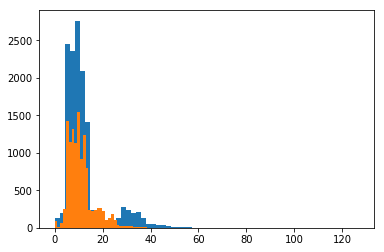

In [95]:
new_data=eliminaAnomaliasPorVelocidad(datamar, "datamarCorrV")

In [104]:
def eliminaRegistrosPorVelocidadVertical(dataset):
    
    vel = dataset.velocidad_v
    
    #Calculo el filtro de datos anómalos
    sigma_velocidad_v= np.std(vel)
    
    hist=plt.hist(vel, bins=60)

    binmax=np.where(hist[0]==hist[0].max())[0][0]
    val_binmax=hist[1][binmax]
    filtro=find_nearest(hist[1],math.ceil(val_binmax+sigma_velocidad_v*2))
    
    #Recorro lo valores de la velocidad
    lista= list()

    for i in np.arange(0,len(vel)):
    
        #n es el valor i de la lista de velocidad
       
        n=vel[i]

        #Si no es el primer valor de la lista
        #Y tampo es el último
        if(i>=1 and i != len(vel)-1):
        
            media=list()
            num=0
        
            #Si i es el segundo elemento de la lista
            #o el anteúltimo, solo cogeré el valor 
            #inmediatemente anterior y siguiente a i
            if(i==1 or i== len(vel)-2):
                num=1
            elif(i==2 or i == len(vel)-3):  #Si es el tercero o el antepenultimo, 
                                            #cojo dos valores inmediatamente anteriores
                                            #y siguientes para la media
                num=2
            else:                           #Para el resto cojo los tres anteriores
                                            #y los tres siguientes
                num=3

            if(num !=0):
                for j in np.arange(-num, num):
                    value=0
                
                    if(j<0):
                        value = lista[i+j]
                    else:
                        value = dataset.velocidad[i+j]
                
                    media.append(value)
           
            n= sum(media)/len(media)
            
            
        if(vel[i] > n*1.5 or vel[i] >filtro):
            n=-99
        else:
            n=vel[i]
        
        lista.append(n)
    
    dataset['velocidad_v']=lista
    
    dataset = dataset.drop(dataset[dataset.velocidad_v==-99].index)
    dataset = dataset.reset_index(drop=True)
    return(dataset)

In [105]:
def eliminaAnomaliasPorVelocidadVertical(dataset,nombreNuevo):
    i=3
    while(i!=0):
        dataset=eliminaRegistrosPorVelocidadVertical(dataset)
        calculosDetectarAnomalias(dataset, nombreNuevo)
        dataset= pd.read_csv(nombreNuevo+".csv")
        i-=1
    return(dataset)

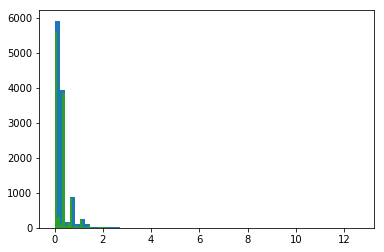

In [106]:
new_data_2=eliminaAnomaliasPorVelocidadVertical(new_data, "datamarCorr1")

In [108]:
sum(data.distancia)
sum(new_data_2.distancia)

45279.502055317964

45031.76854005826

In [15]:
detectaYEliminaAnomalias(pathGeneral="./", nombreFichero="Marat_n_BCN_sobran_kilometros_.csv")


In [21]:
prueba= pd.read_csv("Marat_n_BCN_sobran_kilometros__XKAnomalias.csv")


In [111]:
def corregirDistancia(dataset):
    sigma_distancia= np.std(dataset['distancia'])
    sigma_velocidad = np.std(dataset['velocidad'])
   
    new_lista= list()
    
    for i in np.arange(0, len(dataset.velocidad)):
        
        dprima = dataset.distancia[i]
        d = dataset.distancia[i]
        v = dataset.velocidad[i]
        
        if(d!=0):
            dprima= d/(1+((sigma_distancia*1.5)/d)**2)
            
        new_lista.append(dprima)
        
    return(new_lista)

In [112]:
def corregirVelocidad(dataset):
    
    new_list = list()    
    
    time=dataset['time']
    
    for i in np.arange(0, len(dataset.time)):
        if( i == 0):
            new_list.append(0)
        else:
            #velocidad
            t1=time[i-1].replace('.000', '')
            t2=time[i].replace( '.000', '')
            time_dt1= formateaFecha(t1,'%Y-%m-%dT%H:%M:%SZ')
            time_dt2= formateaFecha(t2,'%Y-%m-%dT%H:%M:%SZ')
            
            v= calculaVelocidadKM(time_dt1, time_dt2, dataset.distancia[i])
            new_list.append(v)
        
    return(new_list)

In [113]:
def detectaYEliminaAnomalias2(pathGeneral, nombreFichero):
    data = pd.read_csv(pathGeneral+nombreFichero) #./Maraton.csv
    new_fichero = nombreFichero.replace(".csv", "_CalcAnomalias") #Maraton.csv -> Maraton_CalcAnomalias
    calculosDetectarAnomalias(data, new_fichero)#Maraton_CalcAnomalias.csv
    data= pd.read_csv(new_fichero+".csv")#Maraton_CalcAnomalias.csv
    new_fichero = new_fichero.replace("_CalcAnomalias", "_SinAnomaliasV")#Maraton_SinAnomaliasV
    data_sinV = eliminaAnomaliasPorVelocidad(data, new_fichero)
    new_fichero = new_fichero.replace("_SinAnomaliasV", "_SinAnomalias")
    data_sinVV=eliminaAnomaliasPorVelocidadVertical(data_sinV, new_fichero)
    new_distancia = corregirDistancia(data_sinVV)
    data_sinVV.distancia= new_distancia
    new_velocidad= corregirVelocidad(data_sinVV)
    data_sinVV.velocidad = new_velocidad
    new_fichero = new_fichero.replace("_SinAnomalias", "_Final")
    print(sum(data_sinVV.distancia))
    data_sinVV.to_csv(new_fichero+".csv")
    

In [115]:
detectaYEliminaAnomalias2(pathGeneral="./", nombreFichero="datamar.csv")

41976.8843599434


In [50]:
prueba = pd.read_csv( "pruebamediamar_Final.csv")

In [51]:
sum(prueba.distancia)

21060.19536043755